<a href="https://colab.research.google.com/github/RomulusGwelt/data-mining-kbtu-fall-2019/blob/master/FinalDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading dataset

In [209]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#download the dataset
!kaggle datasets download kmlyldrn/earthquakes
!mkdir models

-rw-r--r-- 1 root root 63 Dec 13 12:56 kaggle.json
earthquakes.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘models’: File exists


In [210]:
!unzip earthquakes.zip

Archive:  earthquakes.zip
replace Earthquakes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Importing libraries

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import numpy as np

import tensorflow as tf
import keras, datetime
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications.xception import preprocess_input
from keras_preprocessing.image import ImageDataGenerator
from keras.applications import xception
from keras.regularizers import l1, l2

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from cyclicLR import CyclicLR

import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show
 
import matplotlib.image as mpimg

import numpy as np 
import pandas as pd 

from math import ceil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime, date

from keras.models import load_model
import cv2
from sklearn.decomposition import PCA


# Preparing data


In [212]:
df = pd.read_csv('Earthquakes.csv')
df

,No,Date(UTC),Ref1,Source Description 1,Latitude,Longitude,Depth,Constant Deg.,Source No 2,Source Description 2,Type,Magnitude,Source No 3,Source Description 3
0,0,2018-10-14 15:08:32,0,,36.8578,44.4161,16.97,No,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA
1,0,2018-10-10 09:08:24,0,,37.4341,35.8520,7.02,No,7,AFAD-DDA,Mw,4.1,7,AFAD-DDA
2,0,2018-10-02 15:29:03,0,,37.6878,37.4016,10.27,No,7,AFAD-DDA,Mw,4.4,7,AFAD-DDA
3,0,2018-09-28 00:26:32,0,,37.2003,30.4376,78.07,No,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA
4,0,2018-09-26 02:52:21,0,,35.6846,26.7266,42.77,No,7,AFAD-DDA,Mw,4.5,7,AFAD-DDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,6,1900-02-06 15:09:00,2,No Second data,38.1200,31.2900,10.00,Yes,2,Ambraseys-Finkel 1987,MS,5.7,2,Ambraseys-Finkel 1987
6570,5,1900-01-30 01:00:00,2,No Second data,37.8300,27.7100,10.00,Yes,2,Ambraseys-Finkel 1987,MS,4.4,2,Ambraseys-Finkel 1987
6571,4,1900-01-27 02:30:00,2,No Second data,37.6300,37.3700,10.00,Yes,2,Ambraseys-Finkel 1987,MS,4.8,2,Ambraseys-Finkel 1987
6572,3,1900-01-24 03:00:00,2,No Second data,39.5400,26.1400,10.00,Yes,2,Ambraseys-Finkel 1987,MS,5.2,2,Ambraseys-Finkel 1987


In [213]:
df.describe()

,No,Ref1,Latitude,Longitude,Depth,Source No 2,Magnitude,Source No 3
count,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000
mean,5499.501977,0.088683,38.461697,33.084180,24.983027,10.145117,4.467600,6.776544
std,3976.820893,0.406717,1.634089,6.280525,27.758711,12.798807,0.485719,5.412018
min,0.000000,0.000000,35.670000,25.850000,0.000000,1.000000,4.000000,1.000000
25%,1865.250000,0.000000,36.992250,27.805475,10.000000,5.000000,4.100000,5.000000
50%,5261.500000,0.000000,38.621150,30.159500,13.000000,5.000000,4.300000,5.000000
75%,8819.750000,0.000000,39.565500,39.256775,33.000000,7.000000,4.700000,7.000000
max,12674.000000,4.000000,42.386900,45.149500,212.000000,41.000000,7.900000,40.000000


In [214]:
df['Date(UTC)'][0].split(' ')

['2018-10-14', '15:08:32']

In [0]:
def split_date(date_string):
  return date_string.split(' ')

In [0]:
dates = []
times = []
for i in range(len(df)):
  cur_date, cur_time = split_date(df.loc[i].iloc[1])
  dates.append(cur_date)
  times.append(cur_time)
dates = pd.Series(dates)
times = pd.Series(times)

In [217]:
df.insert(1, 'Date', dates, allow_duplicates = True)
df.insert(2, 'Time', times, allow_duplicates = True)
df.drop(columns = 'Date(UTC)', inplace = True)
df

,No,Date,Time,Ref1,Source Description 1,Latitude,Longitude,Depth,Constant Deg.,Source No 2,Source Description 2,Type,Magnitude,Source No 3,Source Description 3
0,0,2018-10-14,15:08:32,0,,36.8578,44.4161,16.97,No,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA
1,0,2018-10-10,09:08:24,0,,37.4341,35.8520,7.02,No,7,AFAD-DDA,Mw,4.1,7,AFAD-DDA
2,0,2018-10-02,15:29:03,0,,37.6878,37.4016,10.27,No,7,AFAD-DDA,Mw,4.4,7,AFAD-DDA
3,0,2018-09-28,00:26:32,0,,37.2003,30.4376,78.07,No,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA
4,0,2018-09-26,02:52:21,0,,35.6846,26.7266,42.77,No,7,AFAD-DDA,Mw,4.5,7,AFAD-DDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,6,1900-02-06,15:09:00,2,No Second data,38.1200,31.2900,10.00,Yes,2,Ambraseys-Finkel 1987,MS,5.7,2,Ambraseys-Finkel 1987
6570,5,1900-01-30,01:00:00,2,No Second data,37.8300,27.7100,10.00,Yes,2,Ambraseys-Finkel 1987,MS,4.4,2,Ambraseys-Finkel 1987
6571,4,1900-01-27,02:30:00,2,No Second data,37.6300,37.3700,10.00,Yes,2,Ambraseys-Finkel 1987,MS,4.8,2,Ambraseys-Finkel 1987
6572,3,1900-01-24,03:00:00,2,No Second data,39.5400,26.1400,10.00,Yes,2,Ambraseys-Finkel 1987,MS,5.2,2,Ambraseys-Finkel 1987


In [218]:
df = df.sort_values(['Date', 'Time'], ascending=[True, True])
df= df.reset_index(drop=True)
df

,No,Date,Time,Ref1,Source Description 1,Latitude,Longitude,Depth,Constant Deg.,Source No 2,Source Description 2,Type,Magnitude,Source No 3,Source Description 3
0,2,1900-01-18,15:30:00,2,No Second data,37.7900,28.2100,10.00,Yes,2,Ambraseys-Finkel 1987,MS,4.4,2,Ambraseys-Finkel 1987
1,3,1900-01-24,03:00:00,2,No Second data,39.5400,26.1400,10.00,Yes,2,Ambraseys-Finkel 1987,MS,5.2,2,Ambraseys-Finkel 1987
2,4,1900-01-27,02:30:00,2,No Second data,37.6300,37.3700,10.00,Yes,2,Ambraseys-Finkel 1987,MS,4.8,2,Ambraseys-Finkel 1987
3,5,1900-01-30,01:00:00,2,No Second data,37.8300,27.7100,10.00,Yes,2,Ambraseys-Finkel 1987,MS,4.4,2,Ambraseys-Finkel 1987
4,6,1900-02-06,15:09:00,2,No Second data,38.1200,31.2900,10.00,Yes,2,Ambraseys-Finkel 1987,MS,5.7,2,Ambraseys-Finkel 1987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,0,2018-09-26,02:52:21,0,,35.6846,26.7266,42.77,No,7,AFAD-DDA,Mw,4.5,7,AFAD-DDA
6570,0,2018-09-28,00:26:32,0,,37.2003,30.4376,78.07,No,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA
6571,0,2018-10-02,15:29:03,0,,37.6878,37.4016,10.27,No,7,AFAD-DDA,Mw,4.4,7,AFAD-DDA
6572,0,2018-10-10,09:08:24,0,,37.4341,35.8520,7.02,No,7,AFAD-DDA,Mw,4.1,7,AFAD-DDA


In [0]:
def calculate_days(date_string_1, date_string_2):

  date_1 = datetime.strptime(date_string_1, '%Y-%m-%d')
  date_2 = datetime.strptime(date_string_2, '%Y-%m-%d')

  d1=date(year = date_1.year, month = date_1.month, day = date_1.day)
  d2=date(year = date_2.year, month = date_2.month, day = date_2.day)

  return (d1 - d2).days

In [0]:
def time_in_hours(date_string):
  
  date_num = datetime.strptime(date_string, '%H:%M:%S')

  hr=((date_num.hour * 60) + date_num.minute) / (24 * 60)

  return hr

In [221]:
begin_date = '1900-01-01'
df['Time gap'] = ""
df['Converted Date'] = ""
df['Converted Time'] = ""
df['Time gap'].loc[0] = calculate_days(df['Date'][0], begin_date)
df['Converted Date'].loc[0] = 0
df['Converted Time'].loc[0] = time_in_hours(df['Time'].loc[0])
for i in range (1, len(df['Date'])):
  df['Time gap'].loc[i] = calculate_days(df['Date'][i], df['Date'][i - 1])
  df['Converted Date'].loc[i] = calculate_days(df['Date'][i], begin_date)
  df['Converted Time'].loc[i] = time_in_hours(df['Time'][i])
df.drop(columns = ['Date', 'Time'], inplace=True)
df

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,No,Ref1,Source Description 1,Latitude,Longitude,Depth,Constant Deg.,Source No 2,Source Description 2,Type,Magnitude,Source No 3,Source Description 3,Time gap,Converted Date,Converted Time
0,2,2,No Second data,37.7900,28.2100,10.00,Yes,2,Ambraseys-Finkel 1987,MS,4.4,2,Ambraseys-Finkel 1987,17,0,0.645833
1,3,2,No Second data,39.5400,26.1400,10.00,Yes,2,Ambraseys-Finkel 1987,MS,5.2,2,Ambraseys-Finkel 1987,6,23,0.125
2,4,2,No Second data,37.6300,37.3700,10.00,Yes,2,Ambraseys-Finkel 1987,MS,4.8,2,Ambraseys-Finkel 1987,3,26,0.104167
3,5,2,No Second data,37.8300,27.7100,10.00,Yes,2,Ambraseys-Finkel 1987,MS,4.4,2,Ambraseys-Finkel 1987,3,29,0.0416667
4,6,2,No Second data,38.1200,31.2900,10.00,Yes,2,Ambraseys-Finkel 1987,MS,5.7,2,Ambraseys-Finkel 1987,7,36,0.63125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,0,0,,35.6846,26.7266,42.77,No,7,AFAD-DDA,Mw,4.5,7,AFAD-DDA,14,43367,0.119444
6570,0,0,,37.2003,30.4376,78.07,No,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA,2,43369,0.0180556
6571,0,0,,37.6878,37.4016,10.27,No,7,AFAD-DDA,Mw,4.4,7,AFAD-DDA,4,43373,0.645139
6572,0,0,,37.4341,35.8520,7.02,No,7,AFAD-DDA,Mw,4.1,7,AFAD-DDA,8,43381,0.380556


In [0]:
df['Converted Time'] = pd.to_numeric(df['Converted Time'])

In [223]:
df['Constant Deg.'] = df['Constant Deg.'].replace({'No' : 0, 'Yes' : 1})
df

,No,Ref1,Source Description 1,Latitude,Longitude,Depth,Constant Deg.,Source No 2,Source Description 2,Type,Magnitude,Source No 3,Source Description 3,Time gap,Converted Date,Converted Time
0,2,2,No Second data,37.7900,28.2100,10.00,1,2,Ambraseys-Finkel 1987,MS,4.4,2,Ambraseys-Finkel 1987,17,0,0.645833
1,3,2,No Second data,39.5400,26.1400,10.00,1,2,Ambraseys-Finkel 1987,MS,5.2,2,Ambraseys-Finkel 1987,6,23,0.125000
2,4,2,No Second data,37.6300,37.3700,10.00,1,2,Ambraseys-Finkel 1987,MS,4.8,2,Ambraseys-Finkel 1987,3,26,0.104167
3,5,2,No Second data,37.8300,27.7100,10.00,1,2,Ambraseys-Finkel 1987,MS,4.4,2,Ambraseys-Finkel 1987,3,29,0.041667
4,6,2,No Second data,38.1200,31.2900,10.00,1,2,Ambraseys-Finkel 1987,MS,5.7,2,Ambraseys-Finkel 1987,7,36,0.631250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,0,0,,35.6846,26.7266,42.77,0,7,AFAD-DDA,Mw,4.5,7,AFAD-DDA,14,43367,0.119444
6570,0,0,,37.2003,30.4376,78.07,0,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA,2,43369,0.018056
6571,0,0,,37.6878,37.4016,10.27,0,7,AFAD-DDA,Mw,4.4,7,AFAD-DDA,4,43373,0.645139
6572,0,0,,37.4341,35.8520,7.02,0,7,AFAD-DDA,Mw,4.1,7,AFAD-DDA,8,43381,0.380556


In [0]:
cat_cols=list(df.dtypes[df.dtypes=='object'].index)#[:-1]

In [0]:
df = df.rename(columns={"Constant Deg.": "ConstantDeg"})

In [226]:
for c in cat_cols:
    print(c)
    print('========')
    print(df[c].unique())
    print()

Source Description 1
['No Second data' 'No Time Data' ' ' 'No Day Data'
 'No Minute and Second Data']

Source Description 2
['Ambraseys-Finkel 1987' 'Ayhan ve Di?.1981' 'Ambraseys-Jackson 1997' 'AS'
 'UNS' 'Alsan ve Di?.1975' 'ISS' 'Gutenberg-Richter 1954' 'VKR'
 'Kalafat ve Di?.2011' 'BCIS' 'CGS' 'MOS' 'ISC' 'EHB' 'USCGS' 'ATH' 'LAO'
 'NAO' 'NEIC' 'EIDC' 'EMSC-CSEM' 'GBZT' 'NEIS' 'AFAD-DDA' 'KRDEA-ISK']

Type
['MS' 'mb' 'Ml' 'Mw' 'Md' 'md' 'Mwp' 'ML']

Source Description 3
['Ambraseys-Finkel 1987' 'Ayhan ve Di?.1981' 'Ambraseys-Jackson 1997' 'AS'
 'UNS' 'Alsan ve Di?.1975' 'Gutenberg-Richter 1954' 'VKR'
 'Kalafat ve Di?.2011' 'MOS' 'ISC' 'USGS' 'USCGS' 'ATH' 'LAO' 'NEIS'
 'NEIC' 'EMSC-CSEM' 'HRVD-GCMT' 'NAO' 'THE' 'HFS-HFS1' 'EIDC' 'GBZT' 'LDG'
 'JSO' 'DUSS' 'SOF' 'NIC' 'AFAD-DDA' 'ISN' 'KRDEA-ISK']



In [0]:
def pct_more_than_1(pct):
    return ('%1.f%%' % pct) if pct > 1 else ''

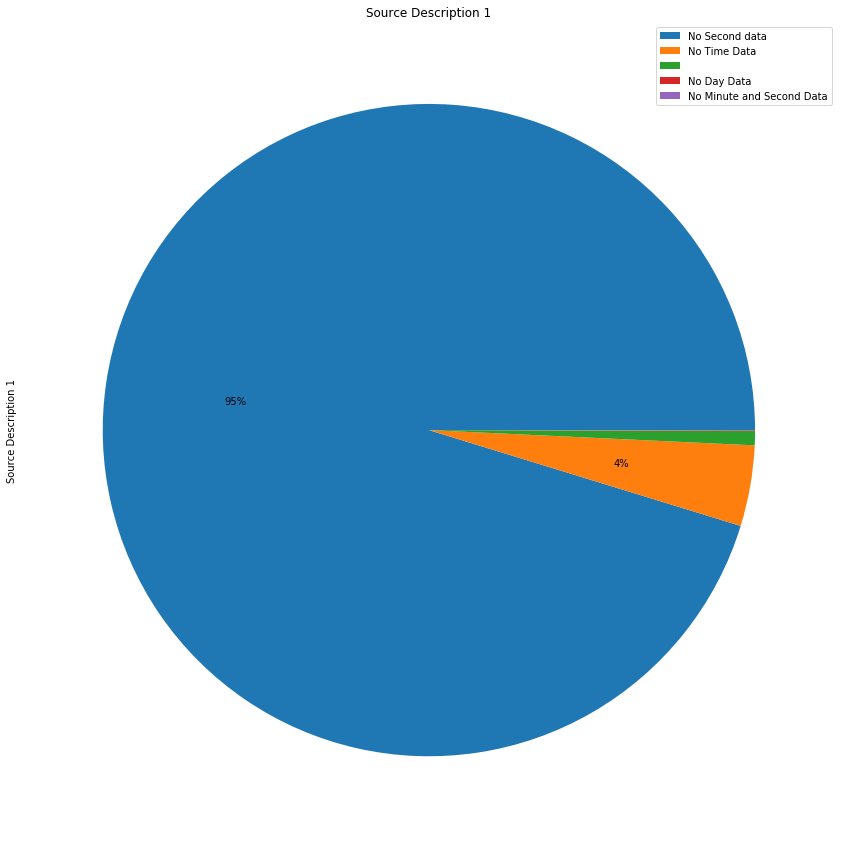

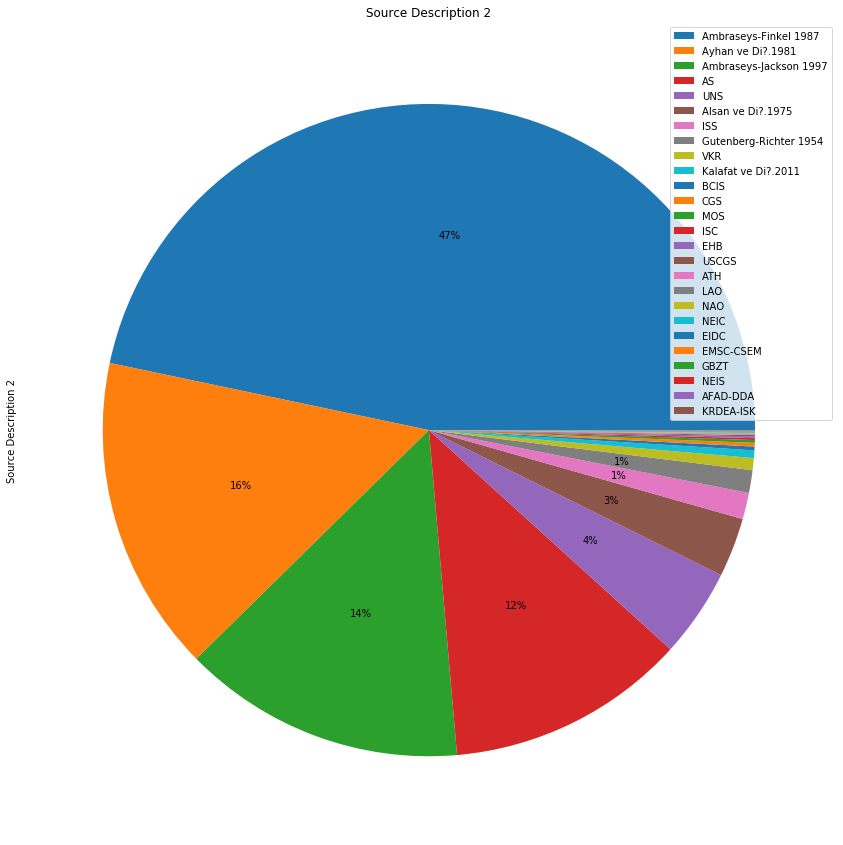

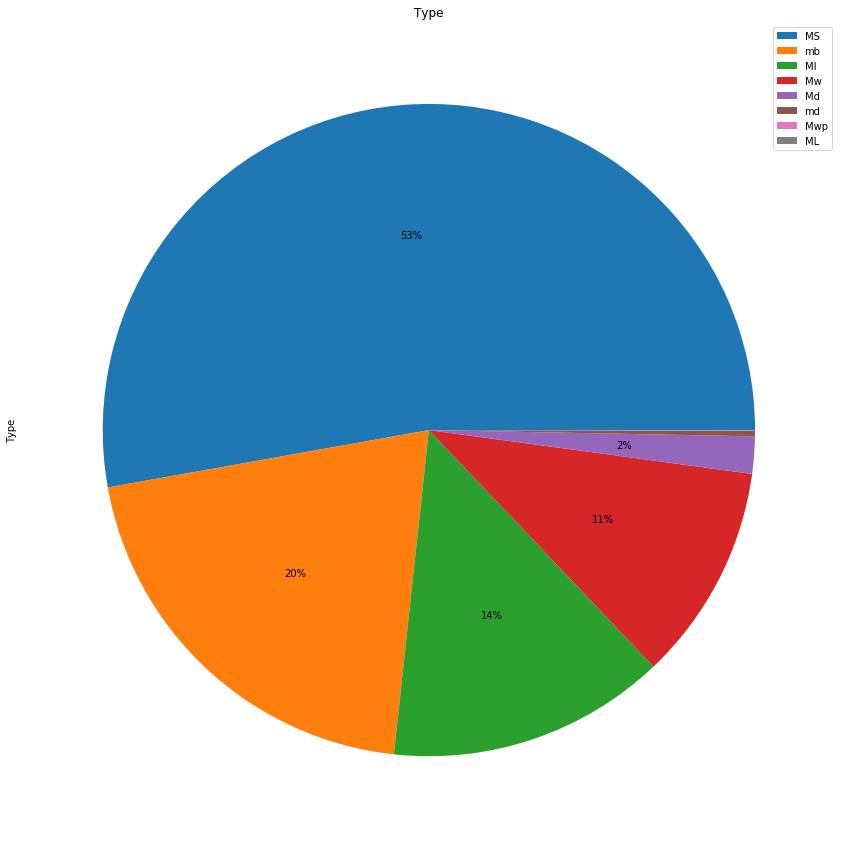

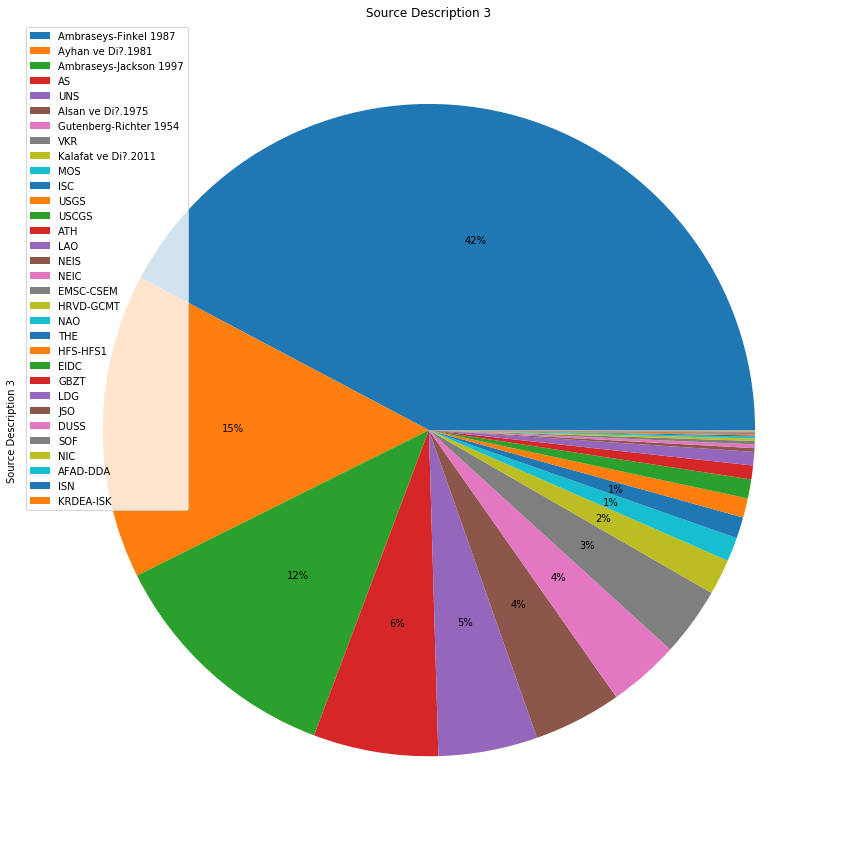

In [228]:
for col in list(df.dtypes[df.dtypes=='object'].index):
  # print(pd.Series(df[col].value_counts()))
  df[col].value_counts().plot(kind='pie', autopct = pct_more_than_1, labels=None, figsize=(15,15), title=col)
  plt.legend(df[col].unique())
  plt.show()  

In [229]:
df.drop(columns=['No', 'Ref1', 'Source Description 1', 'Source No 2',
                'Source Description 2', 'Source No 3', 'Source Description 3',
                'Type'], inplace = True)
df

,Latitude,Longitude,Depth,ConstantDeg,Magnitude,Time gap,Converted Date,Converted Time
0,37.7900,28.2100,10.00,1,4.4,17,0,0.645833
1,39.5400,26.1400,10.00,1,5.2,6,23,0.125000
2,37.6300,37.3700,10.00,1,4.8,3,26,0.104167
3,37.8300,27.7100,10.00,1,4.4,3,29,0.041667
4,38.1200,31.2900,10.00,1,5.7,7,36,0.631250
...,...,...,...,...,...,...,...,...
6569,35.6846,26.7266,42.77,0,4.5,14,43367,0.119444
6570,37.2003,30.4376,78.07,0,4.0,2,43369,0.018056
6571,37.6878,37.4016,10.27,0,4.4,4,43373,0.645139
6572,37.4341,35.8520,7.02,0,4.1,8,43381,0.380556


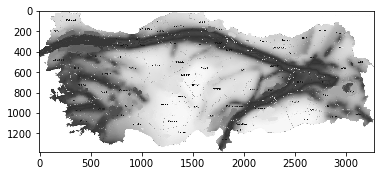

In [230]:
img=cv2.imread("risk_map_clean.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

(<matplotlib.image.AxesImage at 0x7f2eb4f10240>, Text(0.5, 1.0, 'Blurred'))

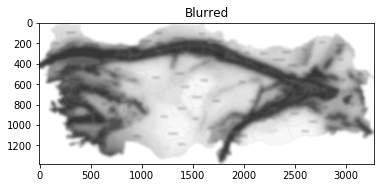

In [231]:
blur = cv2.GaussianBlur(img,(7,7),0)
for i in range(105):
  blur = cv2.GaussianBlur(blur,(7,7),0)
plt.imshow(blur, cmap='gray', vmin=0, vmax=255),plt.title('Blurred')

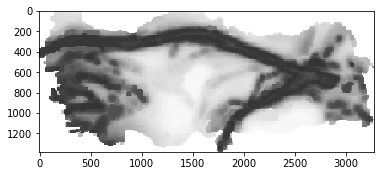

In [232]:
size=6
increment=2
epoch=4
# recovered_img=blur.copy()
recovered_img = img.copy()

for i in range(0,epoch):
  
  width_step=np.shape(recovered_img)[1]/size
  height_step=np.shape(recovered_img)[0]/size

  for h in range(0, int(height_step)):
    for w in range(0, int(width_step)):

      window = recovered_img[h * size:(h + 1) * size, w * size:(w + 1) * size]
      if i == 0:
        window = window.max()
      else:
        window = window.min()

      recovered_img[h * size:(h + 1) * size, w * size:(w + 1) * size] = window

  size += increment
plt.imshow(recovered_img, cmap='gray', vmin=0, vmax=255)

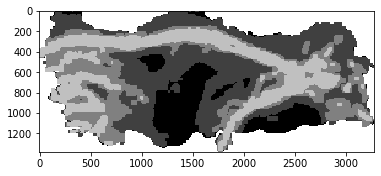

In [233]:
risk_map = recovered_img.copy()

high=75
medium=150
low=225
no_data=250
default=5

risk_map=np.where(risk_map<=high, 4, risk_map)
risk_map=np.where(((risk_map>high) & (risk_map<=medium)), 3, risk_map)
risk_map=np.where(((risk_map>medium) & (risk_map<=low)), 2, risk_map)
risk_map=np.where(((risk_map>low) & (risk_map<=no_data)), 1, risk_map)
risk_map=np.where(risk_map>no_data, default, risk_map)
plt.imshow(risk_map, cmap='gray', vmin=1, vmax=5)

In [0]:
def risk(latitude, longitude):
  
  west=25.67
  east=44.81
  south=35.81
  north=42.10

  real_width = east - west
  real_height = north - south

  map_width = np.shape(risk_map)[1]
  map_height = np.shape(risk_map)[0]

  width_ratio = map_width/(real_width*100)
  height_ratio = map_height/(real_height*100)

  # Calculating pixels to look up for the grade
  easting = longitude-west
  northing = latitude-south

  pixel_to_right = int(round(easting*100*width_ratio))
  pixel_to_up = map_height-int(round(northing*100*height_ratio))

  # Correction of the error caused by floating points
  if pixel_to_right >= map_width:
    pixel_to_right = map_width-1

  if pixel_to_up >= map_height:
    pixel_to_up = map_height-1
  
  grade=risk_map[pixel_to_up, pixel_to_right]

  return grade

In [235]:
print(risk_map.shape)
grades = []
for i in range(len(df)):
  grades.append(risk(df.loc[i].iloc[0], df.loc[i].iloc[1]))
df['Risk Grade']=pd.Series(grades)
df

(1380, 3275)


,Latitude,Longitude,Depth,ConstantDeg,Magnitude,Time gap,Converted Date,Converted Time,Risk Grade
0,37.7900,28.2100,10.00,1,4.4,17,0,0.645833,4
1,39.5400,26.1400,10.00,1,5.2,6,23,0.125000,3
2,37.6300,37.3700,10.00,1,4.8,3,26,0.104167,4
3,37.8300,27.7100,10.00,1,4.4,3,29,0.041667,4
4,38.1200,31.2900,10.00,1,5.7,7,36,0.631250,3
...,...,...,...,...,...,...,...,...,...
6569,35.6846,26.7266,42.77,0,4.5,14,43367,0.119444,5
6570,37.2003,30.4376,78.07,0,4.0,2,43369,0.018056,2
6571,37.6878,37.4016,10.27,0,4.4,4,43373,0.645139,4
6572,37.4341,35.8520,7.02,0,4.1,8,43381,0.380556,2


# Visualizing Data

In [236]:
df.describe()

,Latitude,Longitude,Depth,ConstantDeg,Magnitude,Time gap,Converted Date,Converted Time,Risk Grade
count,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000
mean,38.461697,33.084180,24.983027,0.111348,4.467600,6.599483,30481.392455,0.494042,3.836021
std,1.634089,6.280525,27.758711,0.314586,0.485719,14.517822,10361.943997,0.294303,1.005025
min,35.670000,25.850000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000
25%,36.992250,27.805475,10.000000,0.000000,4.100000,0.000000,25657.000000,0.232639,3.000000
50%,38.621150,30.159500,13.000000,0.000000,4.300000,2.000000,32860.000000,0.493056,4.000000
75%,39.565500,39.256775,33.000000,0.000000,4.700000,6.000000,38488.000000,0.750694,5.000000
max,42.386900,45.149500,212.000000,1.000000,7.900000,233.000000,43385.000000,0.999306,5.000000


In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
Latitude          6574 non-null float64
Longitude         6574 non-null float64
Depth             6574 non-null float64
ConstantDeg       6574 non-null int64
Magnitude         6574 non-null float64
Time gap          6574 non-null int64
Converted Date    6574 non-null int64
Converted Time    6574 non-null float64
Risk Grade        6574 non-null int64
dtypes: float64(5), int64(4)
memory usage: 462.4 KB


In [0]:
def position(latitude, longitude):
  
  west=25.67
  east=44.81
  south=35.81
  north=42.10

  real_width = east - west
  real_height = north - south

  map_width = np.shape(risk_map)[1]
  map_height = np.shape(risk_map)[0]

  width_ratio = map_width/(real_width*100)
  height_ratio = map_height/(real_height*100)

  # Calculating pixels to look up for the grade
  easting = longitude-west
  northing = latitude-south

  pixel_to_right = int(round(easting*100*width_ratio))
  pixel_to_up = map_height-int(round(northing*100*height_ratio))

  # Correction of the error caused by floating points
  if pixel_to_right >= map_width:
    pixel_to_right = map_width-1

  if pixel_to_up >= map_height:
    pixel_to_up = map_height-1
  
  return [pixel_to_up, pixel_to_right]

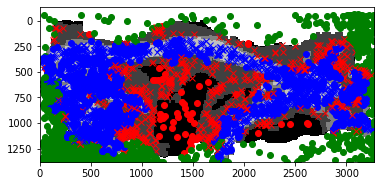

In [239]:
plt.imshow(risk_map, cmap='gray', vmin=1, vmax=5)
colours = ['ro', 'rx', 'bo', 'bx', 'go']
grades = []
for i in range(len(df)):
  pos = position(df['Latitude'][i], df['Longitude'][i])
  # print(pos[0])
  plt.plot(pos[1], pos[0], colours[int(df['Risk Grade'][i] - 1)])
  # grades.append(position(df.loc[i].iloc[0], df.loc[i].iloc[1]))
# plt.plot(grades[:,0], grades[:,1], colo)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


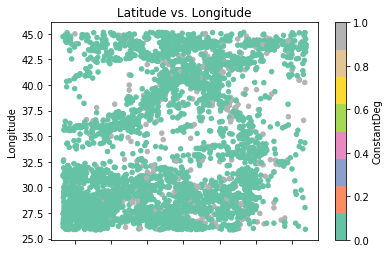

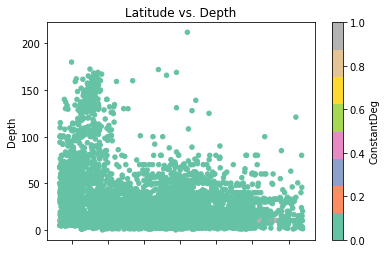

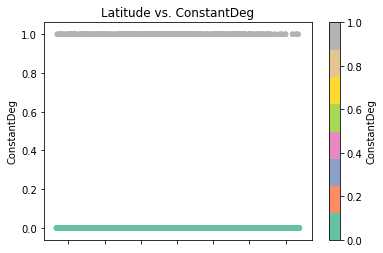

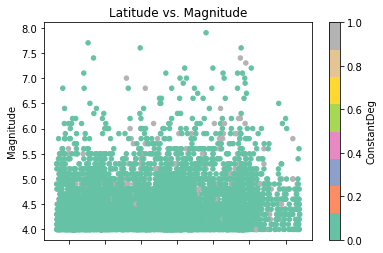

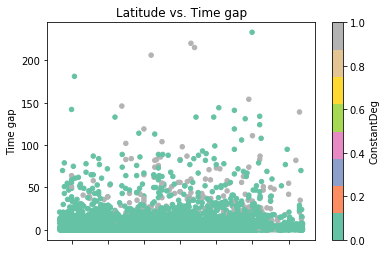

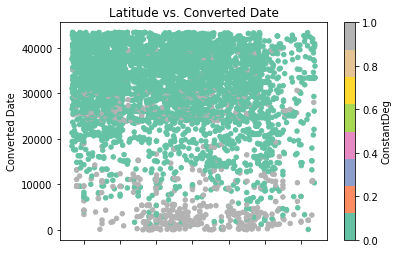

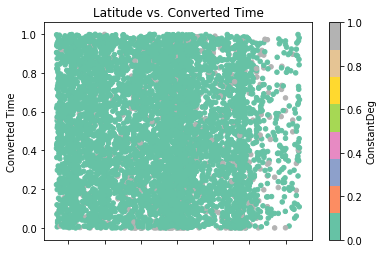

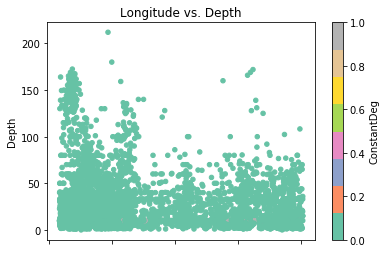

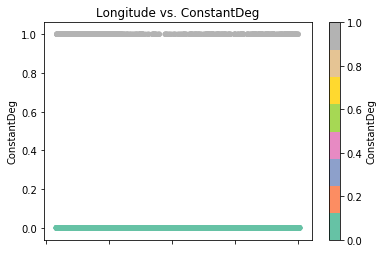

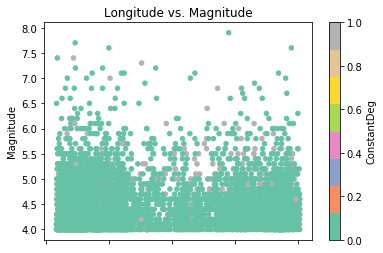

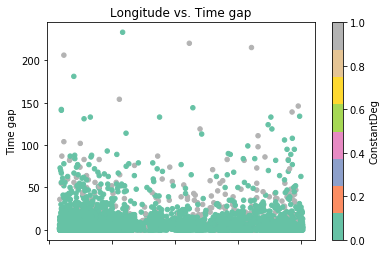

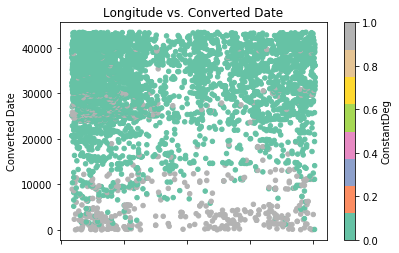

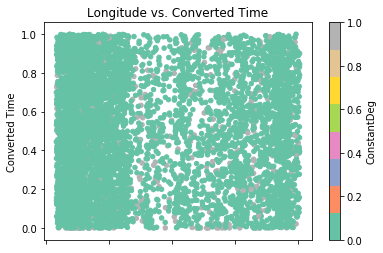

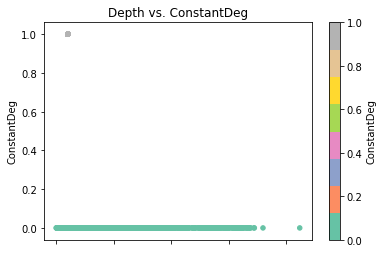

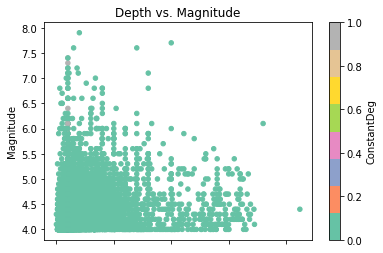

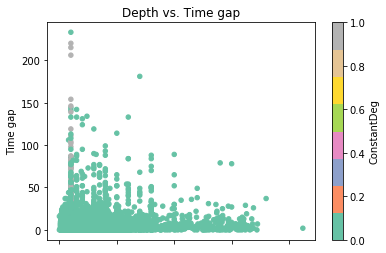

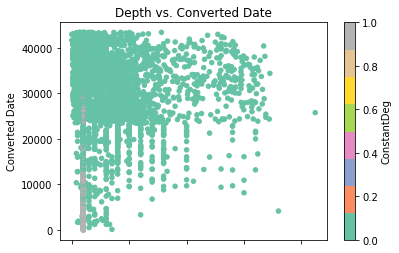

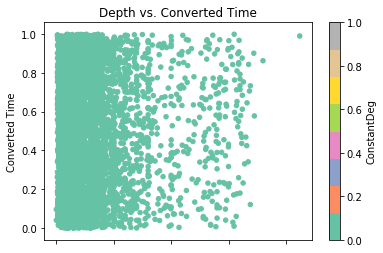

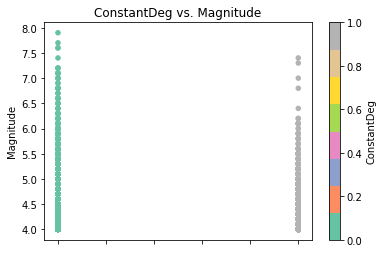

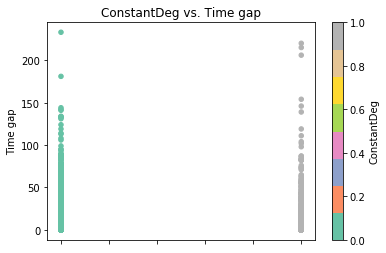

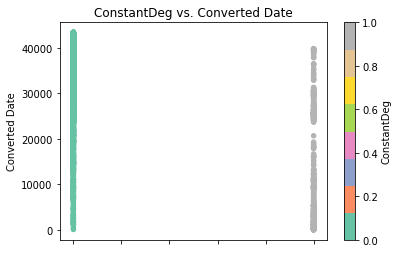

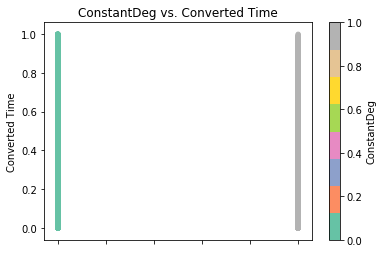

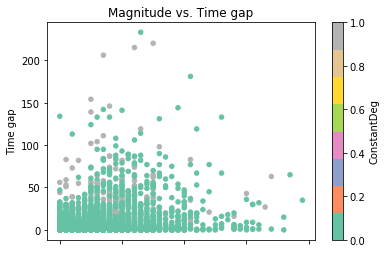

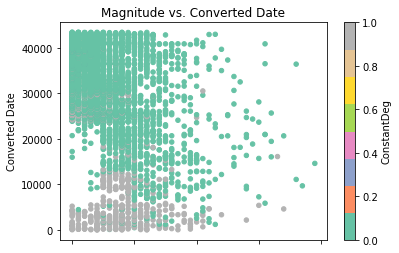

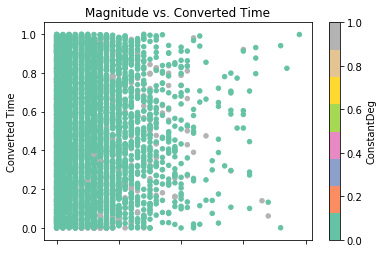

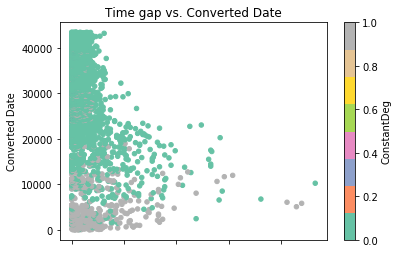

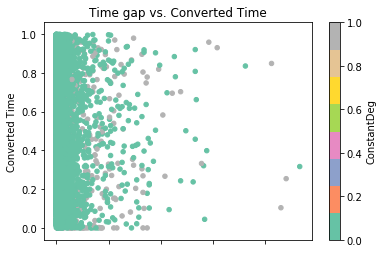

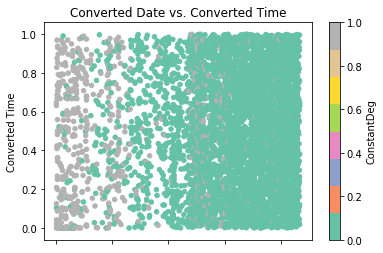

In [240]:
for i in range(len(df.columns) - 1):
    # print (len(df.columns) - 1)
    # break
    for j in range(i + 1,len(df.columns) - 1):
        # print(i,j)
        # df.plot.scatter(x = df.columns[i], y = df.columns[j], colormap='Set2', c='ConstantDeg', title=df.columns[i]+' vs. '+df.columns[j], loglog=True)
        df.plot.scatter(x = df.columns[i], y = df.columns[j], colormap='Set2', c='ConstantDeg', title=df.columns[i]+' vs. '+df.columns[j],)        

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


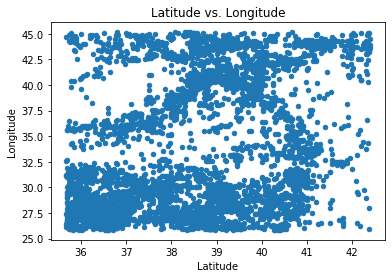

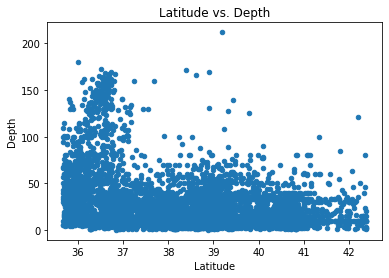

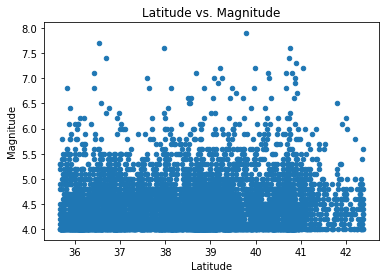

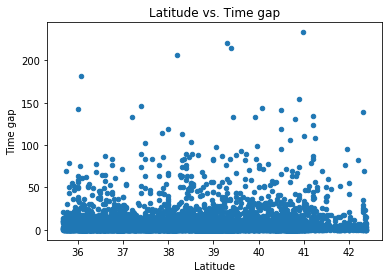

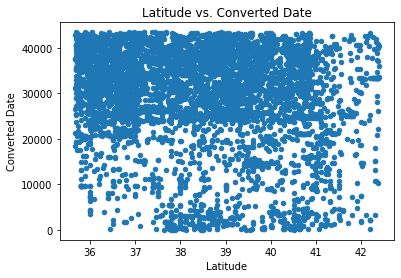

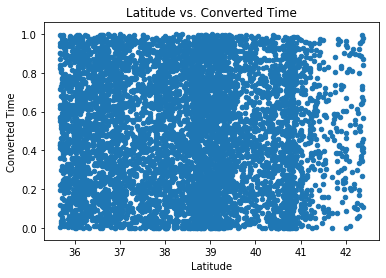

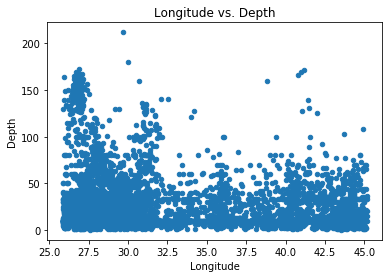

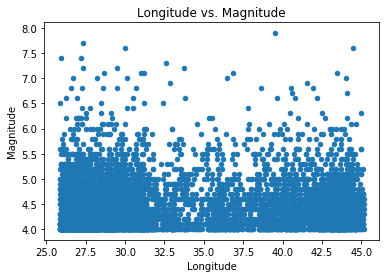

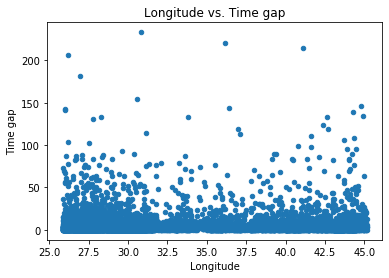

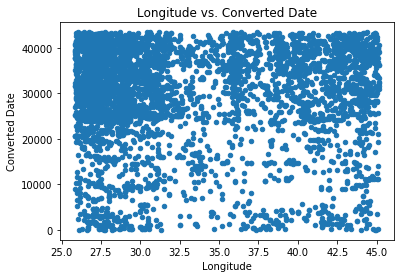

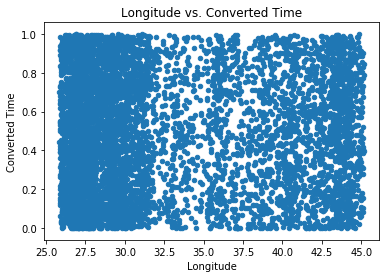

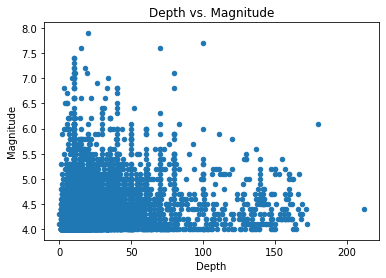

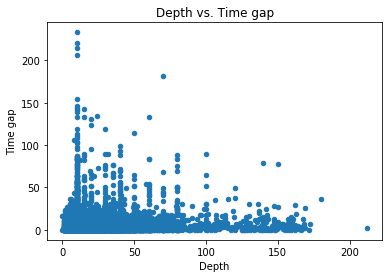

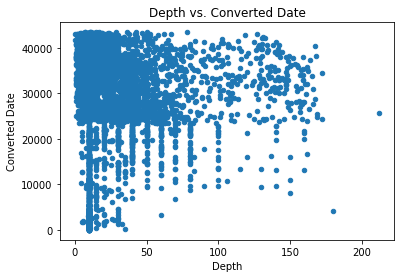

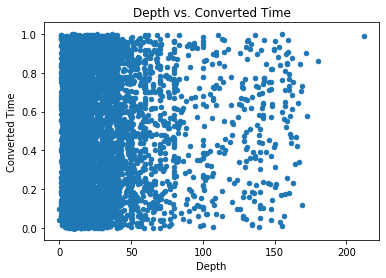

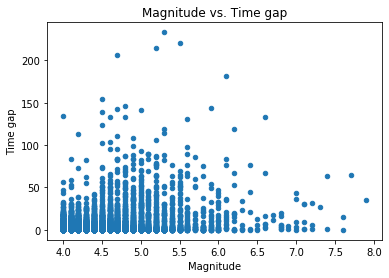

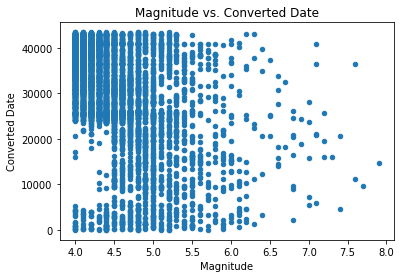

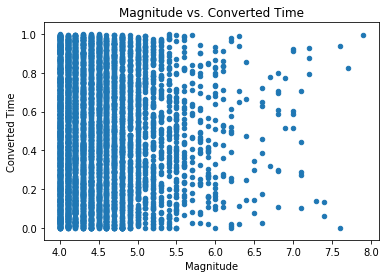

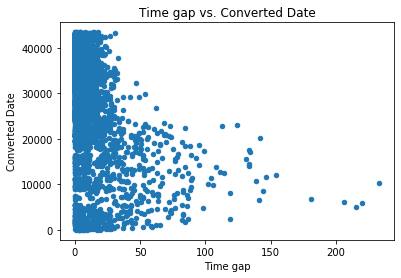

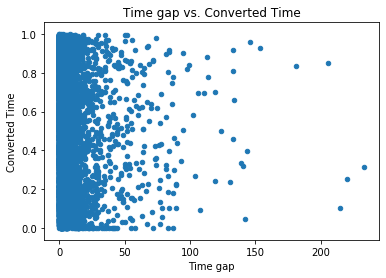

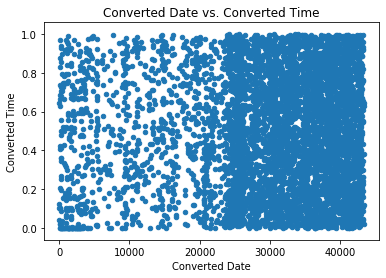

In [241]:
records = df[df['ConstantDeg'] == 1].drop(columns='ConstantDeg')
for i in range(len(records.columns) - 1):
    # print (len(df.columns) - 1)
    # break
    for j in range(i + 1,len(records.columns) - 1):
        # print(i,j)
        # df.plot.scatter(x = df.columns[i], y = df.columns[j], colormap='Set2', c='ConstantDeg', title=df.columns[i]+' vs. '+df.columns[j], loglog=True)
        df.plot.scatter(x = records.columns[i], y = records.columns[j], title=records.columns[i]+' vs. '+records.columns[j],)
        # break

In [242]:
records.describe()

,Latitude,Longitude,Depth,Magnitude,Time gap,Converted Date,Converted Time,Risk Grade
count,732.000000,732.000000,732.0,732.000000,732.000000,732.000000,732.000000,732.000000
mean,38.747936,32.955483,10.0,4.619126,13.349727,14110.438525,0.469819,3.732240
std,1.574119,6.176387,0.0,0.503819,24.276070,11950.778265,0.310080,1.041886
min,35.690000,25.880000,10.0,4.000000,0.000000,0.000000,0.000000,1.000000
25%,37.657500,27.712700,10.0,4.200000,1.000000,2991.000000,0.183854,3.000000
50%,38.776800,30.100000,10.0,4.600000,4.000000,10340.500000,0.473264,4.000000
75%,40.000000,38.632500,10.0,4.900000,15.000000,25653.000000,0.746354,5.000000
max,42.352900,45.038500,10.0,7.400000,220.000000,39804.000000,0.998611,5.000000


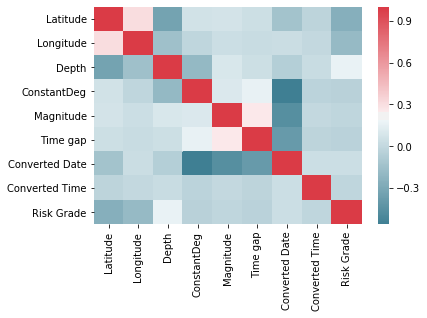

In [243]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

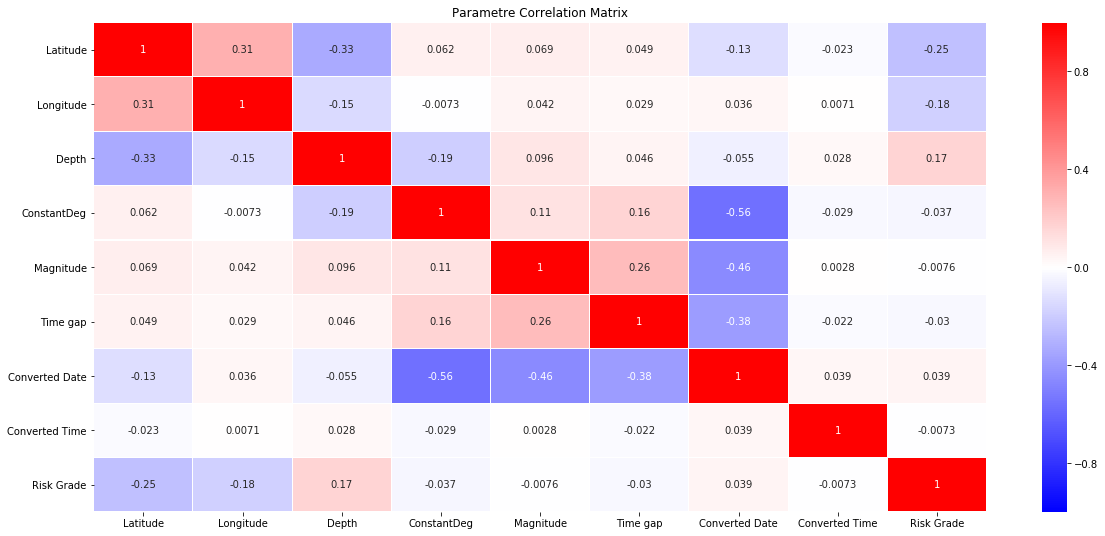

In [244]:
corr=df.corr()

plt.figure(figsize=(20,9))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="bwr", annot=True, linewidth=0.1)
plt.title("Parametre Correlation Matrix")
plt.show()


# Building model


In [0]:
x = df.drop(columns = ['Latitude', 'Longitude', 'Magnitude', 'Converted Date']).to_numpy()
y = df[['Latitude', 'Longitude', 'Magnitude', 'Converted Date']].to_numpy()

In [246]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_train

array([[3.93000000e+01, 0.00000000e+00, 0.00000000e+00, 3.60416667e-01,
        3.00000000e+00],
       [1.03000000e+01, 0.00000000e+00, 0.00000000e+00, 4.58333333e-01,
        4.00000000e+00],
       [3.10000000e+00, 0.00000000e+00, 1.00000000e+00, 3.26388889e-01,
        4.00000000e+00],
       ...,
       [3.30000000e+01, 0.00000000e+00, 2.30000000e+01, 8.58333333e-01,
        5.00000000e+00],
       [2.27000000e+01, 0.00000000e+00, 0.00000000e+00, 2.26388889e-01,
        2.00000000e+00],
       [9.40000000e+00, 0.00000000e+00, 1.10000000e+01, 3.68055556e-02,
        4.00000000e+00]])

In [247]:
scaler_x=MinMaxScaler(feature_range=(0,1))
scaler_y=MinMaxScaler(feature_range=(0,1))

x_train = scaler_x.fit_transform(x_train)
x_val = scaler_x.fit_transform(x_val)
x_test = scaler_x.fit_transform(x_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.fit_transform(y_val)
y_test = scaler_y.fit_transform(y_test)
y_train

array([[0.27491957, 0.21021815, 0.10810811, 0.60082978],
       [0.373153  , 0.05581118, 0.        , 0.86995505],
       [0.70614871, 0.00469973, 0.        , 0.87269794],
       ...,
       [0.49033306, 0.995435  , 0.08108108, 0.77335485],
       [0.56477896, 0.55505467, 0.08108108, 0.8371557 ],
       [0.33506613, 0.16874968, 0.        , 0.9194883 ]])

In [0]:
model = Sequential()
# model.add(Dense(1000, input_shape = (5, ), activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(250, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
model.add(Dense(128, input_shape = (5, ), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4))
# optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae'])

In [0]:
step_size = 500
clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

In [250]:
model.fit(x_train, y_train, epochs=700, batch_size=32, shuffle=True,
  validation_data=(x_val, y_val), verbose=1,
  callbacks=[
    clr,
    ModelCheckpoint('./models/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
  ]
)

Train on 4207 samples, validate on 1052 samples
Epoch 1/700
4207/4207 [==============================] - 1s 296us/step - loss: 0.4304 - mean_absolute_error: 0.4951 - val_loss: 0.1031 - val_mean_absolute_error: 0.2481

Epoch 00001: val_loss improved from inf to 0.10312, saving model to ./models/model.h5
Epoch 2/700
4207/4207 [==============================] - 1s 226us/step - loss: 0.0767 - mean_absolute_error: 0.2073 - val_loss: 0.0639 - val_mean_absolute_error: 0.1925

Epoch 00002: val_loss improved from 0.10312 to 0.06391, saving model to ./models/model.h5
Epoch 3/700
4207/4207 [==============================] - 1s 223us/step - loss: 0.0570 - mean_absolute_error: 0.1838 - val_loss: 0.0668 - val_mean_absolute_error: 0.1993

Epoch 00003: val_loss did not improve from 0.06391
Epoch 4/700
4207/4207 [==============================] - 1s 220us/step - loss: 0.0557 - mean_absolute_error: 0.1815 - val_loss: 0.0783 - val_mean_absolute_error: 0.2060

Epoch 00004: val_loss did not improve from 0.

# Evaluating prediciton

In [251]:
model = load_model('models/model.h5')
prediction = model.predict(x_test)
print(prediction)
print(x_test)
print(y_test)
prediction = scaler_y.inverse_transform(prediction)
answers = scaler_y.inverse_transform(y_test)

[[0.4935659  0.511632   0.13674258 0.72237414]
 [0.52379173 0.4164386  0.09349549 0.8338461 ]
 [0.15966487 0.31087035 0.09751067 0.7091758 ]
 ...
 [0.47822478 0.42550048 0.06800682 0.8529679 ]
 [0.38319838 0.34157884 0.08834133 0.79799384]
 [0.25221428 0.26908997 0.18291277 0.36491495]]
[[0.12521739 0.         0.02912621 0.14315497 0.25      ]
 [0.04       0.         0.00485437 0.36414177 0.75      ]
 [0.32231884 0.         0.01941748 0.24878388 1.        ]
 ...
 [0.02898551 0.         0.03398058 0.18207088 0.5       ]
 [0.04057971 0.         0.00970874 0.0590688  1.        ]
 [0.05797101 1.         0.02912621 0.16817234 1.        ]]
[[0.56045053 0.5703112  0.         0.80506499]
 [0.77235143 0.29006743 0.         0.84137867]
 [0.01115895 0.07533195 0.03125    0.73684697]
 ...
 [0.4314745  0.95801349 0.125      0.93949258]
 [0.04316086 0.22225622 0.1875     0.7133458 ]
 [0.0485839  0.99224585 0.5        0.07735993]]


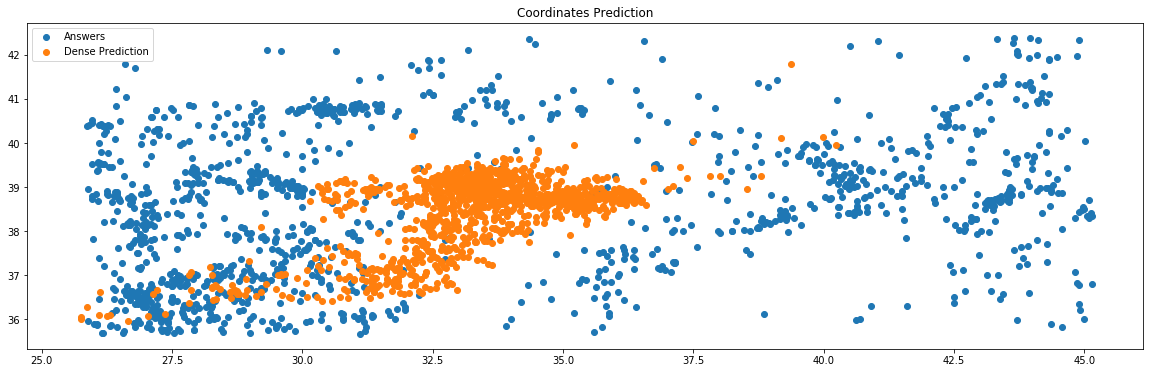

In [252]:
plt.figure(figsize=(20,6))
plt.scatter(answers.T[1], answers.T[0], label = 'Answers')
plt.scatter(prediction.T[1], prediction.T[0], label = 'Dense Prediction')
plt.title("Coordinates Prediction")
plt.legend()
plt.show()

# Model N2

In [0]:
x = df.drop(columns = ['Magnitude', 'Converted Date']).to_numpy()
y = df[['Magnitude', 'Converted Date']].to_numpy()

In [254]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_train

array([[3.75190000e+01, 2.99070000e+01, 3.93000000e+01, ...,
        0.00000000e+00, 3.60416667e-01, 3.00000000e+00],
       [3.81785000e+01, 2.69271000e+01, 1.03000000e+01, ...,
        0.00000000e+00, 4.58333333e-01, 4.00000000e+00],
       [4.04141000e+01, 2.59407000e+01, 3.10000000e+00, ...,
        1.00000000e+00, 3.26388889e-01, 4.00000000e+00],
       ...,
       [3.89652000e+01, 4.50609000e+01, 3.30000000e+01, ...,
        2.30000000e+01, 8.58333333e-01, 5.00000000e+00],
       [3.94650000e+01, 3.65620000e+01, 2.27000000e+01, ...,
        0.00000000e+00, 2.26388889e-01, 2.00000000e+00],
       [3.79228000e+01, 2.91067000e+01, 9.40000000e+00, ...,
        1.10000000e+01, 3.68055556e-02, 4.00000000e+00]])

In [255]:
scaler_x=MinMaxScaler(feature_range=(0,1))
scaler_y=MinMaxScaler(feature_range=(0,1))

x_train = scaler_x.fit_transform(x_train)
x_val = scaler_x.fit_transform(x_val)
x_test = scaler_x.fit_transform(x_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.fit_transform(y_val)
y_test = scaler_y.fit_transform(y_test)
y_train

array([[0.10810811, 0.60082978],
       [0.        , 0.86995505],
       [0.        , 0.87269794],
       ...,
       [0.08108108, 0.77335485],
       [0.08108108, 0.8371557 ],
       [0.        , 0.9194883 ]])

In [0]:
model = Sequential()
# model.add(Dense(1000, input_shape = (5, ), activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(250, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
model.add(Dense(128, input_shape = (7, ), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2))
# optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae'])

In [0]:
step_size = 500
clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

In [258]:
model.fit(x_train, y_train, epochs=700, batch_size=32, shuffle=True,
  validation_data=(x_val, y_val), verbose=1,
  callbacks=[
    clr,
    ModelCheckpoint('./models/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
  ]
)

Train on 4207 samples, validate on 1052 samples
Epoch 1/700
4207/4207 [==============================] - 1s 326us/step - loss: 0.6366 - mean_absolute_error: 0.5696 - val_loss: 0.2527 - val_mean_absolute_error: 0.4106

Epoch 00001: val_loss improved from inf to 0.25272, saving model to ./models/model.h5
Epoch 2/700
4207/4207 [==============================] - 1s 225us/step - loss: 0.0532 - mean_absolute_error: 0.1741 - val_loss: 0.0728 - val_mean_absolute_error: 0.2122

Epoch 00002: val_loss improved from 0.25272 to 0.07284, saving model to ./models/model.h5
Epoch 3/700
4207/4207 [==============================] - 1s 230us/step - loss: 0.0337 - mean_absolute_error: 0.1385 - val_loss: 0.0735 - val_mean_absolute_error: 0.2094

Epoch 00003: val_loss did not improve from 0.07284
Epoch 4/700
4207/4207 [==============================] - 1s 228us/step - loss: 0.0315 - mean_absolute_error: 0.1346 - val_loss: 0.0713 - val_mean_absolute_error: 0.2120

Epoch 00004: val_loss improved from 0.07284 t

# Eval 2

In [259]:
model = load_model('models/model.h5')
prediction = model.predict(x_test)
print(prediction)
print(x_test)
print(y_test)
prediction = scaler_y.inverse_transform(prediction)
answers = scaler_y.inverse_transform(y_test)

[[0.12766777 0.69883144]
 [0.08531187 0.78837985]
 [0.14992765 0.70849156]
 ...
 [0.0908975  0.8552885 ]
 [0.06126814 0.8353154 ]
 [0.29044732 0.24380815]]
[[0.56045053 0.5703112  0.12521739 ... 0.02912621 0.14315497 0.25      ]
 [0.77235143 0.29006743 0.04       ... 0.00485437 0.36414177 0.75      ]
 [0.01115895 0.07533195 0.32231884 ... 0.01941748 0.24878388 1.        ]
 ...
 [0.4314745  0.95801349 0.02898551 ... 0.03398058 0.18207088 0.5       ]
 [0.04316086 0.22225622 0.04057971 ... 0.00970874 0.0590688  1.        ]
 [0.0485839  0.99224585 0.05797101 ... 0.02912621 0.16817234 1.        ]]
[[0.         0.80506499]
 [0.         0.84137867]
 [0.03125    0.73684697]
 ...
 [0.125      0.93949258]
 [0.1875     0.7133458 ]
 [0.5        0.07735993]]


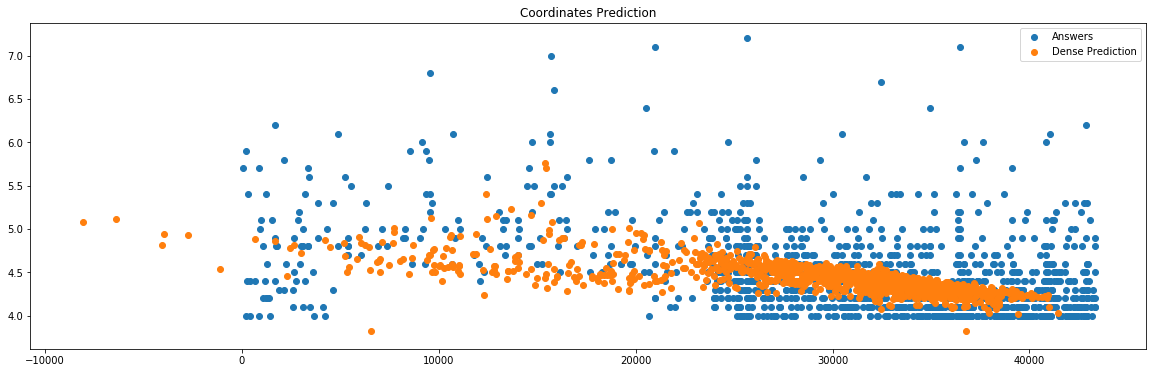

In [260]:
plt.figure(figsize=(20,6))
plt.scatter(answers.T[1], answers.T[0], label = 'Answers')
plt.scatter(prediction.T[1], prediction.T[0], label = 'Dense Prediction')
plt.title("Coordinates Prediction")
plt.legend()
plt.show()